In [ ]:
!pip install tensorflow

In [46]:
# Import necessary libraries 
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from datetime import datetime
from dateutil.parser import parse as dt_parse
import re
from os import listdir
import nltk
from nltk.corpus import stopwords
from seaborn import pairplot
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error


In [47]:
# Function to transform time series data into supervised learning dataset
def series_to_supervised(data, n_in=1):
    # default index
    n_out=1
    dropnan=True
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop non-relevant t columns
    agg.drop(agg.columns[[x for x in range(data.shape[1], 2*data.shape[1]-1)]], axis=1, inplace=True)
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


In [48]:
# Read data from CSV file
PriceswithEmotion = pd.read_csv('C:/Users/gjc53/Desktop/Financial information/Prices_with_Emotion.csv', parse_dates=['Date'], index_col='Date').values
scaler = MinMaxScaler()
scaler = scaler.fit(PriceswithEmotion)
PriceswithEmotion = scaler.fit_transform(PriceswithEmotion)
PriceswithEmotion[:5,:]

array([[0.62730076, 0.65034646, 0.6694626 , 0.6939259 , 0.        ,
        0.93625   , 0.09557721, 0.47000251],
       [0.68887228, 0.66675784, 0.70740271, 0.68160713, 0.        ,
        0.90675   , 0.1398051 , 0.6384403 ],
       [0.63851257, 0.61670314, 0.65493026, 0.65232635, 0.        ,
        0.741     , 0.38830585, 0.89950632],
       [0.62262917, 0.6012035 , 0.62762118, 0.62020279, 0.        ,
        1.        , 0.        , 0.39887875],
       [0.55732038, 0.55935449, 0.59845899, 0.59746044, 0.        ,
        0.        , 0.        , 0.39887875]])

In [49]:
# use series_to_supervised function to construct supervised dataset 
PriceswithEmotion = series_to_supervised(PriceswithEmotion)
PriceswithEmotion

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var8(t)
1,0.627301,0.650346,0.669463,0.693926,0.000000,0.936250,0.095577,0.470003,0.638440
2,0.688872,0.666758,0.707403,0.681607,0.000000,0.906750,0.139805,0.638440,0.899506
3,0.638513,0.616703,0.654930,0.652326,0.000000,0.741000,0.388306,0.899506,0.398879
4,0.622629,0.601204,0.627621,0.620203,0.000000,1.000000,0.000000,0.398879,0.398879
5,0.557320,0.559354,0.598459,0.597460,0.000000,0.000000,0.000000,0.398879,0.540373
...,...,...,...,...,...,...,...,...,...
213,0.610390,0.599289,0.616210,0.598219,0.088298,0.871812,0.120036,0.453679,0.441240
214,0.600112,0.602936,0.633278,0.641808,0.089441,0.879330,0.107826,0.441240,0.438846
215,0.616930,0.645788,0.673266,0.692031,0.124049,0.847808,0.126784,0.438846,0.449204
216,0.678595,0.664023,0.697064,0.684450,0.085655,0.866585,0.130023,0.449204,0.438752


In [50]:
# The dtype of the ndarray must be specified as float32 (default is float64), otherwise it will cause errors when inputting into the LSTM model
PriceswithEmotion = PriceswithEmotion.values.astype(np.float32)
# training sets: tesing sets = 7:3
X_train, X_test, y_train, y_test = train_test_split(PriceswithEmotion[:,:-1], PriceswithEmotion[:,3], test_size=0.3, shuffle=False)

In [51]:
y_train

array([0.6939259 , 0.6816071 , 0.65232635, 0.6202028 , 0.59746045,
       0.5256325 , 0.50857574, 0.5482801 , 0.57007486, 0.56467354,
       0.6063679 , 0.6186866 , 0.5864683 , 0.5315076 , 0.5561452 ,
       0.5902587 , 0.6205818 , 0.65469533, 0.71344644, 0.6698569 ,
       0.704918  , 0.73808396, 0.7200796 , 0.6433242 , 0.62531984,
       0.60447264, 0.636691  , 0.65469533, 0.6281626 , 0.63763857,
       0.6442718 , 0.60542023, 0.5087653 , 0.4945513 , 0.49170852,
       0.4992893 , 0.45285702, 0.39600113, 0.40073913, 0.3742064 ,
       0.40263432, 0.3742064 , 0.3287217 , 0.28797498, 0.29176536,
       0.3182981 , 0.30597934, 0.35714963, 0.31356013, 0.3258789 ,
       0.35904482, 0.4045295 , 0.42537668, 0.41590068, 0.41590068,
       0.40168673, 0.39031556, 0.36094   , 0.33440727, 0.34293565,
       0.32682648, 0.31166494, 0.32682648, 0.29176536, 0.30029374,
       0.2870274 , 0.26049465, 0.20089073, 0.21131432, 0.21605231,
       0.16867241, 0.19615275, 0.22458069, 0.22552828, 0.22363

In [52]:
# reshape input to be 3D [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

In [53]:
# Function to generate LSTM model
def LSTMModelGenerate(Xtrain, Xtest, ytrain, ytest):
    """
    LSTM model construction function
    :param Xtrain: Training set attributes
    :param Xtest: Test set attributes
    :param ytrain: Training set labels
    :param ytest: Test set labels
    :return: history, model (model compilation records and model)
    """
    # Construct LSTM model
    _model = Sequential()
    _model.add(LSTM(64, input_shape=(Xtrain.shape[1], Xtrain.shape[2])))
    _model.add(Dropout(0.4))
    _model.add(Dense(1, activation='relu'))
    _model.compile(loss='mse', optimizer='adam')
    # Model training
    _history = _model.fit(Xtrain, ytrain, epochs=50, batch_size=30, validation_data=(Xtest, ytest), shuffle=False, verbose=0)
    return _history,_model
  
history, model = LSTMModelGenerate(X_train, X_test, y_train, y_test)


D:\ANACONDA\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


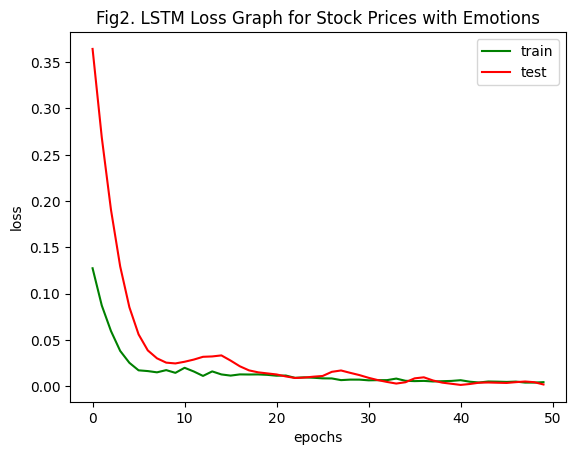

In [54]:
def drawLossGraph(_history, title, num):
    """
    Loss graph drawing, finding the optimal epochs
    :param _history: Training history
    :param title: Chart title
    :param num: Chart number
    :return: None
    """
    plt.plot(_history.history['loss'], color='g', label='train')
    plt.plot(_history.history['val_loss'], color='r', label='test')
    plt.title('Fig'+num+'. '+title)
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.legend()
    savingpath = 'data'+num+'_'+title.replace(' ', '_')+'.png'
    plt.savefig(savingpath, dpi=400, bbox_inches='tight')
    plt.show()
    
drawLossGraph(history, title='LSTM Loss Graph for Stock Prices with Emotions', num='2')

In [55]:
#Because only the result column needs to be inverse transformed,
#the inverse_transform function is not needed.
#Here, a custom function inverse_transform_col is defined for inverse normalization of a specific column.
def inverse_transform_col(_scaler, y, n_col):
    """
    Function for inverse normalization of a specific column
    :param _scaler: sklearn normalization model
    :param y: data column to be inverse normalized
    :param n_col: column number of y during normalization
    :return: inverse normalized result of y
    """
    y = y.copy()
    y -= _scaler.min_[n_col]
    y /= _scaler.scale_[n_col]
    return y


In [56]:
# Function for drawing predicted results graph
def predictGraph(yTrain, yPredict, yTest, timelabels, title, num):
    """
    Function for drawing predicted results graph
    :param yTrain: training set results
    :param yPredict: predicted results of the validation set
    :param yTest: true results of the validation set
    :param timelabels: x-axis tick labels
    :param title: graph title
    :param num: graph number
    :return: None
    """
    len_yTrain = yTrain.shape[0]
    len_y = len_yTrain+yPredict.shape[0]
    # Real curve plot
    plt.plot(np.concatenate([yTrain,yTest]), color='r', label='sample')
    # Prediction curve plot
    plt.plot([x for x in range(len_yTrain,len_y)],yPredict, color='g', label='predict')
    plt.title('Fig'+num+'. '+title)
    plt.xlabel('date')
    plt.ylabel('close')
    plt.legend()
    xticks = [0,len_yTrain,len_y-1]
    xtick_labels = [timelabels[x] for x in xticks]
    plt.xticks(ticks=xticks, labels=xtick_labels, rotation=30)
    savingPath = 'data'+num+'_'+title.replace(' ', '_')+'.png'
    plt.savefig(savingPath, dpi=400, bbox_inches='tight')
    plt.show()

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


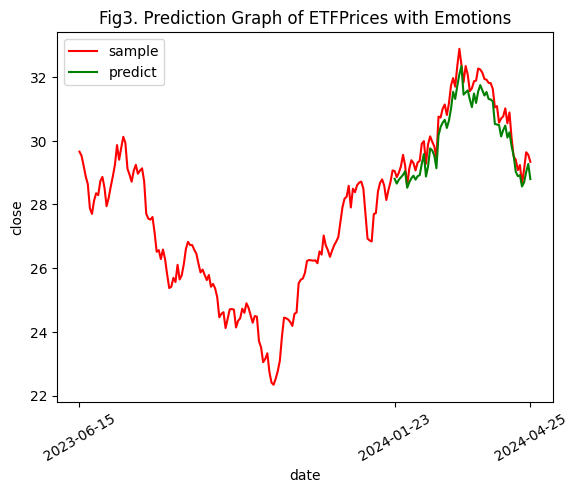

In [57]:
# Pedicting today's stock closing value based on previous day's stock indicators in X_test
# Note: The array generated by predict needs to be reduced to shape=(n_samples, )
y_predict = model.predict(X_test)[:,0]

# Inverse transformation
# Re-reading
PriceswithEmotion = pd.read_csv('C:/Users/gjc53/Desktop/Financial information/Prices_with_Emotion.csv')
col_n = PriceswithEmotion.shape[1]-6
inv_yPredict = inverse_transform_col(scaler, y_predict, col_n)
inv_yTest = inverse_transform_col(scaler, y_test, col_n)
inv_yTrain = inverse_transform_col(scaler, y_train, col_n)
predictGraph(inv_yTrain, inv_yPredict, inv_yTest, timelabels=PriceswithEmotion['Date'].values, title='Prediction Graph of ETFPrices with Emotions', num='3')

In [58]:
# sklearn.metrics.mean_squared_error(y_true, y_pred)
mse = mean_squared_error(inv_yTest, inv_yPredict)
print('The mean squared error (MSE) of the predicted stock data with emotional features is', mse)

带有情感特征的股票数据预测结果的均方误差（MSE）为  0.21584205


In [59]:
def formatData(sharePricesData):
    """
    The function for standardising sample data
    :param sharePricesData: DataFrame of sample data
    :return: X_train, X_test, y_train, y_test, scaler
    """
    _scaler = MinMaxScaler()
    _scaler = _scaler.fit(sharePricesData)
    sharePricesData = _scaler.fit_transform(sharePricesData)
    #Constructing a supervised dataset
    sharePricesData = series_to_supervised(sharePricesData)
    # dtype为float32
    sharePricesData = sharePricesData.values.astype(np.float32)
    # split trainning and testing sets
    _X_train, _X_test, _y_train, _y_test = train_test_split(sharePricesData[:,:-1], sharePricesData[:,-1], test_size=0.3, shuffle=False)
    # reshape input
    _X_train = _X_train.reshape((_X_train.shape[0], 1, _X_train.shape[1]))
    _X_test = _X_test.reshape((_X_test.shape[0], 1, _X_test.shape[1]))
    return _X_train, _X_test, _y_train, _y_test, _scaler

In [60]:
def invTransformMulti(_scaler, _y_predict, _y_test, _y_train, _col_n):
    # inverse transformation
    _inv_yPredict = inverse_transform_col(_scaler, _y_predict, _col_n)
    _inv_yTest = inverse_transform_col(_scaler, _y_test, _col_n)
    _inv_yTrain = inverse_transform_col(_scaler, _y_train, _col_n)
    return _inv_yPredict, _inv_yTest, _inv_yTrain

In [61]:
ETFPrice = pd.read_csv('C:/Users/gjc53/Desktop/Financial information/adjusted_ETFPrice_1year.csv', parse_dates=['Date'], index_col='Date').values
X_train, X_test, y_train, y_test, scaler = formatData(ETFPrice)
history, model = LSTMModelGenerate(X_train, X_test, y_train, y_test)

D:\ANACONDA\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


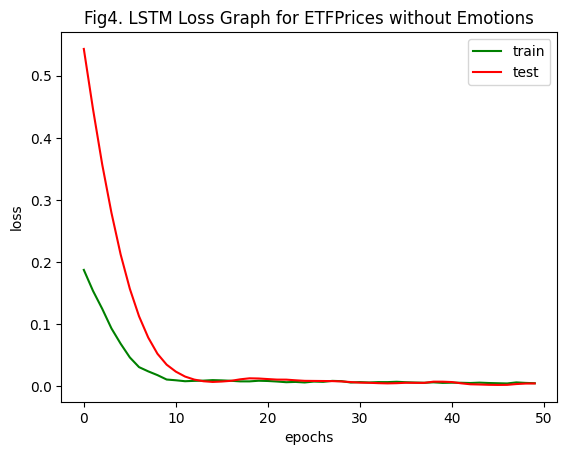

In [62]:
drawLossGraph(history, title='LSTM Loss Graph for ETFPrices without Emotions', num='4')

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


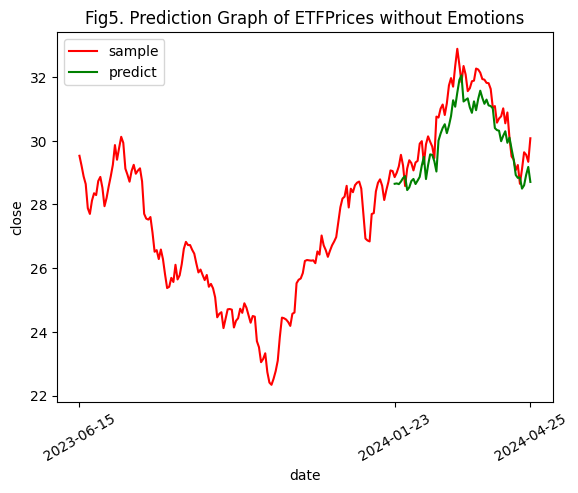

In [63]:
# Prediction
y_predict = model.predict(X_test)[:,0]
# Inverse transformation 
ETFPrice = pd.read_csv('C:/Users/gjc53/Desktop/Financial information/adjusted_ETFPrice_1year.csv')
col_n = ETFPrice.shape[1]-2
inv_yPredict, inv_yTest, inv_yTrain = invTransformMulti(scaler, y_predict, y_test, y_train, col_n)
predictGraph(inv_yTrain, inv_yPredict, inv_yTest, timelabels=ETFPrice['Date'].values, title='Prediction Graph of ETFPrices without Emotions', num='5')


In [64]:
# MSE
mse = mean_squared_error(inv_yTest, inv_yPredict)
print('The mean squared error (MSE) of the prediction results for stock data without emotional features is', mse)

无情感特征的纯技术指标股票数据预测结果的均方误差（MSE）为  0.5460235
